In [6]:
import os
import datetime
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
#import shap

import sys
sys.path.append('/home/rluser/TACTILEDRIVEN_ARTO/UTILITIES')
from PreProcessingFunctions import myfilter, num_transient, sliding_sum_window, select_index, add_padding
from PreProcessingFunctions import WS, WS_B
from PreProcessingFunctions import rename_and_convert_to_txt

from Performance_plotter import plot_f1_score_threshold, plot_precision_recall_curve, plot_confusion_matrix, plot_roc_curve
from XAI_FCN import plot_grad_cam

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report

import tensorflow
gpus = tensorflow.config.list_physical_devices('GPU')
if gpus:    
    for gpu in gpus:
        tensorflow.config.set_logical_device_configuration(
            gpu,
            [tensorflow.config.LogicalDeviceConfiguration(memory_limit=4*1024)])  # Adjust memory limit as needed


from tensorflow.keras.models     import Sequential, Model, load_model
from tensorflow.keras.layers     import Input, Conv1D, Conv2D, BatchNormalization
from tensorflow.keras.layers     import Flatten, Dense, MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D
from tensorflow.keras.layers     import LeakyReLU, ReLU, Activation, Dropout, Lambda
from tensorflow.keras.layers     import concatenate, Concatenate
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.losses     import BinaryCrossentropy
from tensorflow.keras.metrics    import AUC, Precision, Recall
from tensorflow.keras.callbacks  import EarlyStopping

from tensorflow.keras.utils      import plot_model


folder_path = '/home/rluser/TACTILEDRIVEN_ARTO/RobotData_GRIPA320'
data_folder = '/home/rluser/TACTILEDRIVEN_ARTO/ML/DATA/1D_Fnew_GRIP_ScalNorm/'

def load_data(data_folder):
    X_data = []
    y_data = []
    # Get list of all .npz files in the data folder
    npz_files = [file for file in os.listdir(data_folder) if file.endswith('.npz')]
    
    # Load data from each .npz file
    for file in npz_files:
        file_path = os.path.join(data_folder, file)
        data = np.load(file_path)
        X_data.append(data['X'])  # Assuming X_data is stored under 'X' key in the .npz file
        y_data.append(data['y'])  # Assuming y_data is stored under 'y' key in the .npz file
        data.close()
    
    # Convert lists to NumPy arrays
    X_data = np.array(X_data)
    y_data = np.array(y_data)
    
    return X_data, y_data

# Load the data
X_data, y_data = load_data(data_folder)

# Check the shape of loaded data
print("X_data shape:", X_data.shape)
print("y_data shape:", y_data.shape)
print("X_data.[0] shape: ", X_data[0].shape)

TEST_SIZE = 0.4
X_train, X_temp, y_train, y_temp = train_test_split(X_data, y_data, test_size=TEST_SIZE, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"TOTAL DATA: {len(X_data)}  ||  Train = {100*(1-TEST_SIZE)}%  ||  Test = {100*TEST_SIZE}%")
print("Dimensions of X_train:", X_train.shape, "   ||  Dimensions of y_train:", y_train.shape)
print("Dimensions of X_test: ", X_test.shape, "   ||  Dimensions of y_test: ", y_test.shape)
print("Dimensions of X_val:  ", X_val.shape, "   ||  Dimensions of y_val:  ", y_val.shape)

2024-06-06 19:01:28.708365: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-06 19:01:30.922208: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-06-06 19:01:32.967541: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-06 19:01:33.610745: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. 

X_data shape: (1465, 800)
y_data shape: (1465,)
X_data.[0] shape:  (800,)
TOTAL DATA: 1465  ||  Train = 60.0%  ||  Test = 40.0%
Dimensions of X_train: (879, 800)    ||  Dimensions of y_train: (879,)
Dimensions of X_test:  (293, 800)    ||  Dimensions of y_test:  (293,)
Dimensions of X_val:   (293, 800)    ||  Dimensions of y_val:   (293,)


In [2]:
# %load_ext tensorboard
# %tensorboard --logdir TensorBoarLOGS/

# 1 CONVs

/home/rluser/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-06-06 19:01:41.194824: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-06 19:01:41.195115: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 799, 128)       │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 102272)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     6,545,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,545,921 (24.97 MB)

 Trainable params: 6,545,921 (24.97 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


I0000 00:00:1717693302.300334    7336 service.cc:145] XLA service 0x751f80005060 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1717693302.300356    7336 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2024-06-06 19:01:42.413366: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-06 19:01:42.782901: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


24/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5454 - loss: 3.7155

I0000 00:00:1717693304.127750    7336 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.5451 - loss: 3.4335 - val_accuracy: 0.6860 - val_loss: 0.6171
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6350 - loss: 0.6238 - val_accuracy: 0.7338 - val_loss: 0.5793
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6585 - loss: 0.5939 - val_accuracy: 0.7406 - val_loss: 0.5134
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7080 - loss: 0.5278 - val_accuracy: 0.7645 - val_loss: 0.5225
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7483 - loss: 0.4739 - val_accuracy: 0.6143 - val_loss: 0.6503
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7271 - loss: 0.5165 - val_accuracy: 0.7509 - val_loss: 0.5052
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7755 - loss: 0.4552 - val_accuracy: 0.7850 - val_loss: 0.4338
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8139 - loss: 0.3983 - val_accuracy: 0.8225 - val_loss: 0.4700
Ep

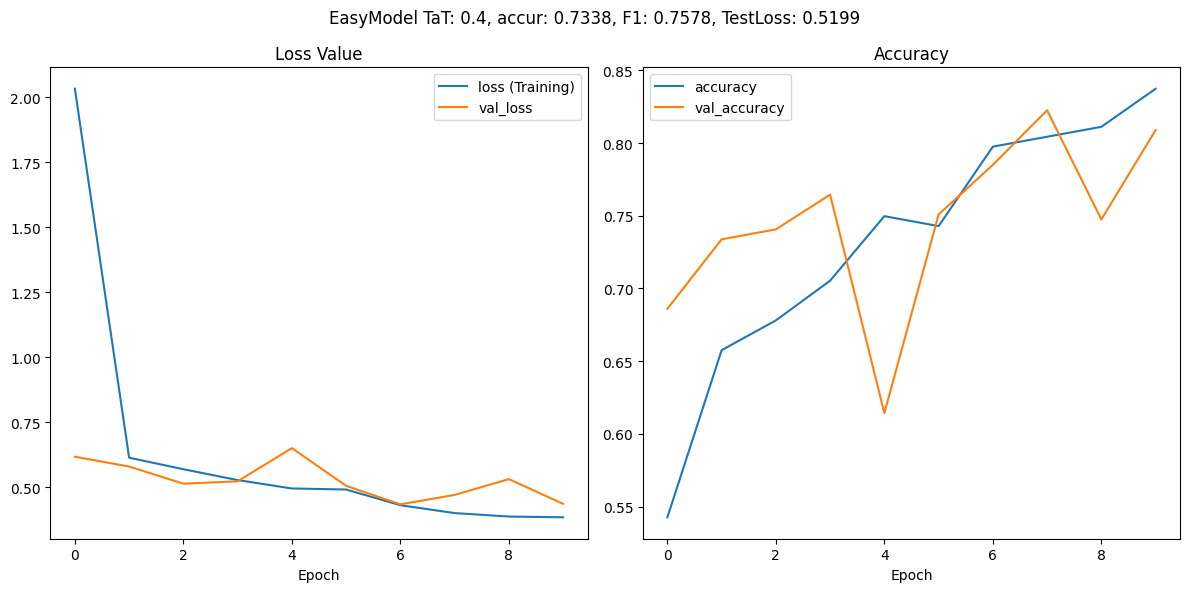

Train loss: 0.3839980959892273
Test val_loss: 0.4357560873031616
Train accuracy: 0.8373151421546936
Accuracy Score: 0.7337883959044369
F1 Score: 0.7577639751552795
Classification Report:
               precision    recall  f1-score   support

         0.0       0.79      0.64      0.70       146
         1.0       0.70      0.83      0.76       147

    accuracy                           0.73       293
   macro avg       0.74      0.73      0.73       293
weighted avg       0.74      0.73      0.73       293



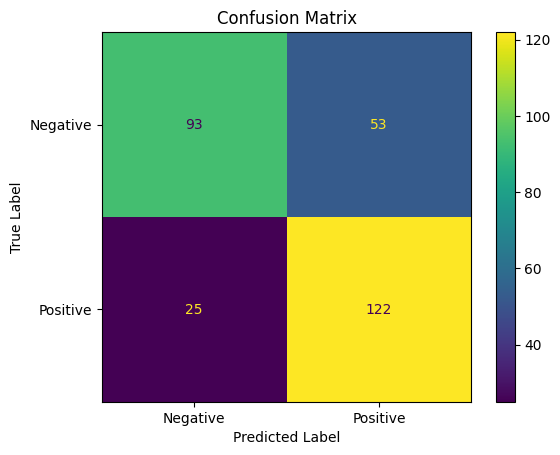

In [7]:
def build_easyModel():
    model = Sequential()
    model.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(WS_B, 1)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

model_name = "1D_easy1Conv_smallKernels"
model = build_easyModel()
model.summary()
model.compile(optimizer=Adam(learning_rate=0.004), loss='binary_crossentropy', metrics=['accuracy'])

# log_dir = "logs/fit/" + f"{model_name}/"+ datetime.datetime.now().strftime("%d-%m-%y--%H:%M:%S")
# tensorboard = TensorBoard(log_dir=log_dir)
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), verbose=1) # , callbacks=[tensorboard]

loss, accuracy = model.evaluate(X_test, y_test)

# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

f1 = f1_score(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))

#to_save_model(model=model, history=history, loss=loss, accuracy=accuracy, f1=f1, model_name=model_name, y_test=y_test, y_pred_binary=y_pred_binary, building_function=build_easyModel)
#compare_and_organize(model_name, build_easyModel, history.history, y_test, y_pred_binary)
plot_confusion_matrix(y_test, y_pred_binary)


# <span style="color:red;"> PLOT F1 SCORE AND F1 WRT ALL the THRESHOLDS</span>


# 2 CONVs 

/home/user/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_10 (Conv1D)              │ (None, 799, 128)       │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 790, 128)       │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 395, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 50560)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │     3,235,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,400,321 (12.97 MB)

 Trainable params: 3,400,321 (12.97 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/18
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.5350 - loss: 0.7874 - val_accuracy: 0.6177 - val_loss: 0.6278
Epoch 2/18
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6015 - loss: 0.6200 - val_accuracy: 0.6894 - val_loss: 0.5571
Epoch 3/18
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6872 - loss: 0.5437 - val_accuracy: 0.7065 - val_loss: 0.5412
Epoch 4/18
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7334 - loss: 0.5109 - val_accuracy: 0.7031 - val_loss: 0.5257
Epoch 5/18
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8025 - loss: 0.4311 - val_accuracy: 0.7372 - val_loss: 0.5208
Epoch 6/18
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7750 - loss: 0.4263 - val_accuracy: 0.7372 - val_loss: 0.4711
Epoch 7/18
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8168 - loss: 0.3786 - val_accuracy: 0.7235 - val_loss: 0.4577
Epoch 8/18
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8315 - loss: 0.3526 - val_accuracy: 0.7338 - v

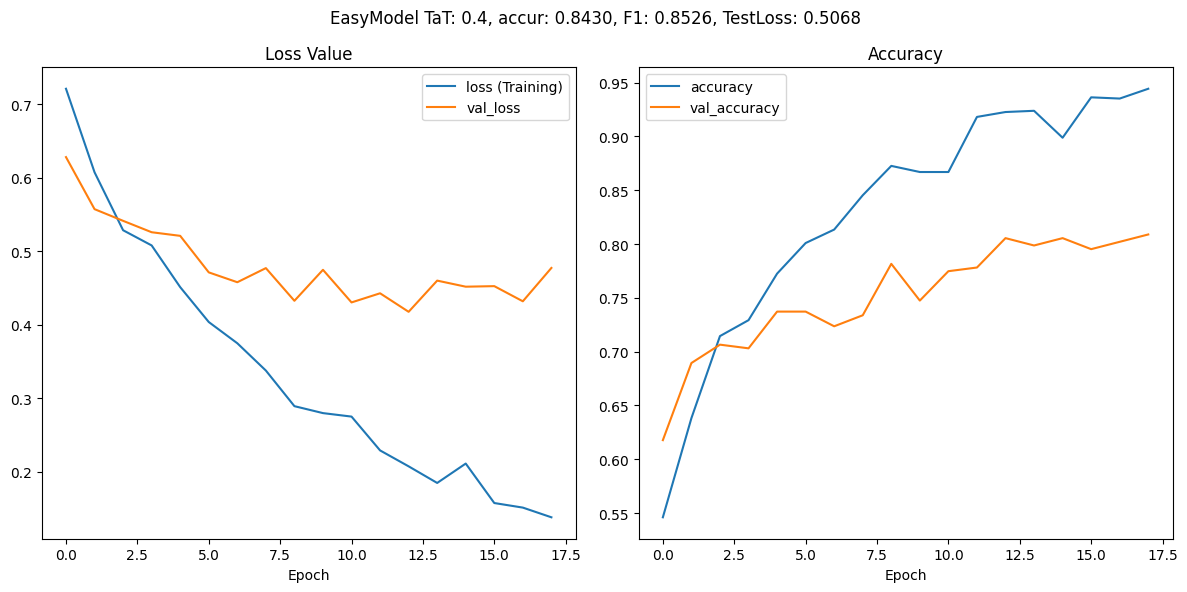

Train loss: 0.13799288868904114
Test val_loss: 0.47710472345352173
Train accuracy: 0.9442548155784607
Accuracy Score: 0.8430034129692833
F1 Score: 0.8525641025641025
Classification Report:
               precision    recall  f1-score   support

         0.0       0.84      0.83      0.83       138
         1.0       0.85      0.86      0.85       155

    accuracy                           0.84       293
   macro avg       0.84      0.84      0.84       293
weighted avg       0.84      0.84      0.84       293



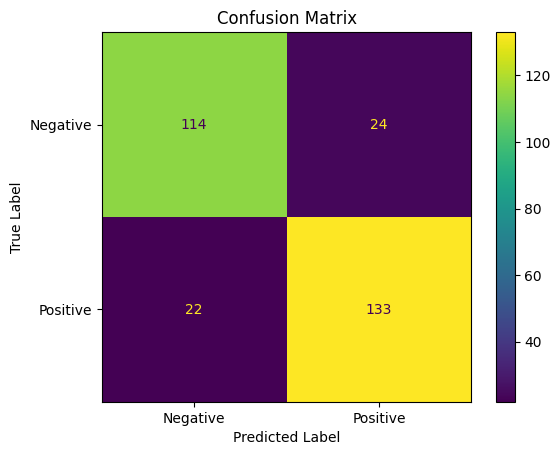

In [7]:
def build_easyModel():
    model = Sequential()
    model.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(WS_B, 1)))
    #model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=128, kernel_size=10, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

model = build_easyModel()
model.summary()
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=18, batch_size=32, validation_data=(X_val, y_val), verbose=1)

loss, accuracy = model.evaluate(X_test, y_test)

# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

f1 = f1_score(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))
plot_confusion_matrix(y_test, y_pred_binary)


# 3 CONVs

/home/user/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_15 (Conv1D)              │ (None, 799, 64)        │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 399, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 396, 128)       │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 198, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 191, 256)       │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_3          │ (None, 256)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 328,513 (1.25 MB)

 Trainable params: 328,513 (1.25 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.5185 - loss: 0.6881 - val_accuracy: 0.5324 - val_loss: 0.6402
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6385 - loss: 0.6377 - val_accuracy: 0.7270 - val_loss: 0.5777
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6624 - loss: 0.5946 - val_accuracy: 0.6962 - val_loss: 0.5038
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7461 - loss: 0.5013 - val_accuracy: 0.6348 - val_loss: 0.6058
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6843 - loss: 0.5678 - val_accuracy: 0.7270 - val_loss: 0.4559
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7366 - loss: 0.4838 - val_accuracy: 0.7440 - val_loss: 0.4291
Epoch 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7649 - loss: 0.4621 - val_accuracy: 0.7577 - val_loss: 0.4338
Epoch 8/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7792 - loss: 0.4316 - val_accuracy: 0.8089 - v

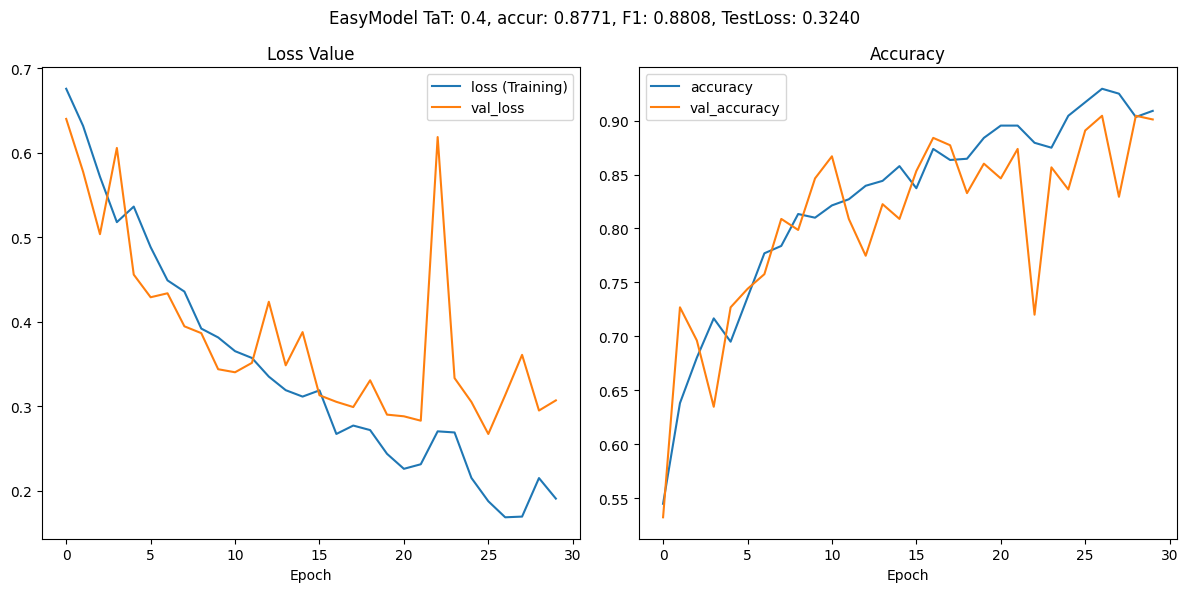

Train loss: 0.19084788858890533
Test val_loss: 0.3070712685585022
Train accuracy: 0.9089874625205994
Accuracy Score: 0.8771331058020477
F1 Score: 0.8807947019867549
Classification Report:
               precision    recall  f1-score   support

         0.0       0.85      0.90      0.87       138
         1.0       0.90      0.86      0.88       155

    accuracy                           0.88       293
   macro avg       0.88      0.88      0.88       293
weighted avg       0.88      0.88      0.88       293



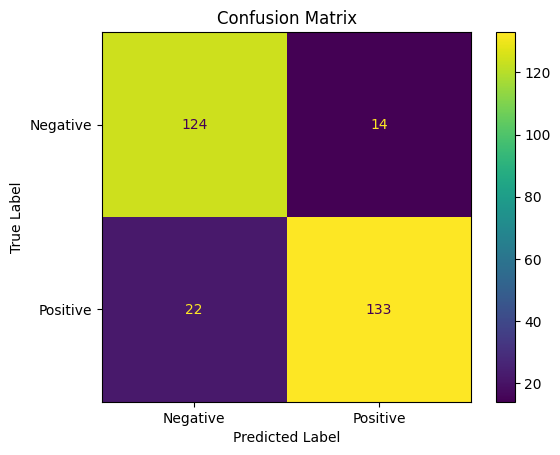

In [9]:
def build_easyModel():
    model = Sequential()
    model.add(Conv1D(64, kernel_size=2, activation='relu', input_shape=(WS_B, 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(128, kernel_size=4, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(256, kernel_size=8, activation='relu'))
    model.add(GlobalMaxPooling1D())
    #model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid')) # activation=(lambda x: x>0)

    return model

model = build_easyModel()
model.summary()
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val), verbose=1)

loss, accuracy = model.evaluate(X_test, y_test)

# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

f1 = f1_score(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))
plot_confusion_matrix(y_test, y_pred_binary)


# 4 CONVs or Still "COMPLEX"

/home/user/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 799, 64)        │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 792, 128)       │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 792, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 783, 256)       │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 783, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 782, 128)       │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 467,777 (1.78 MB)

 Trainable params: 467,777 (1.78 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/16
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 202ms/step - accuracy: 0.5249 - loss: 0.7050 - val_accuracy: 0.4812 - val_loss: 0.6947
Epoch 2/16
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.4667 - loss: 0.7010 - val_accuracy: 0.5085 - val_loss: 0.6934
Epoch 3/16
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.4913 - loss: 0.6936 - val_accuracy: 0.4915 - val_loss: 0.6907
Epoch 4/16
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.5372 - loss: 0.6885 - val_accuracy: 0.5119 - val_loss: 0.6759
Epoch 5/16
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6296 - loss: 0.6537 - val_accuracy: 0.6246 - val_loss: 0.6113
Epoch 6/16
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.6401 - loss: 0.6066 - val_accuracy: 0.6553 - val_loss: 0.5785
Epoch 7/16
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6686 - loss: 0.5770 - val_accuracy: 0.6962 - val_loss: 0.5510
Epoch 8/16
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6820 - loss: 0.5544 - val_accuracy: 0.6416 -

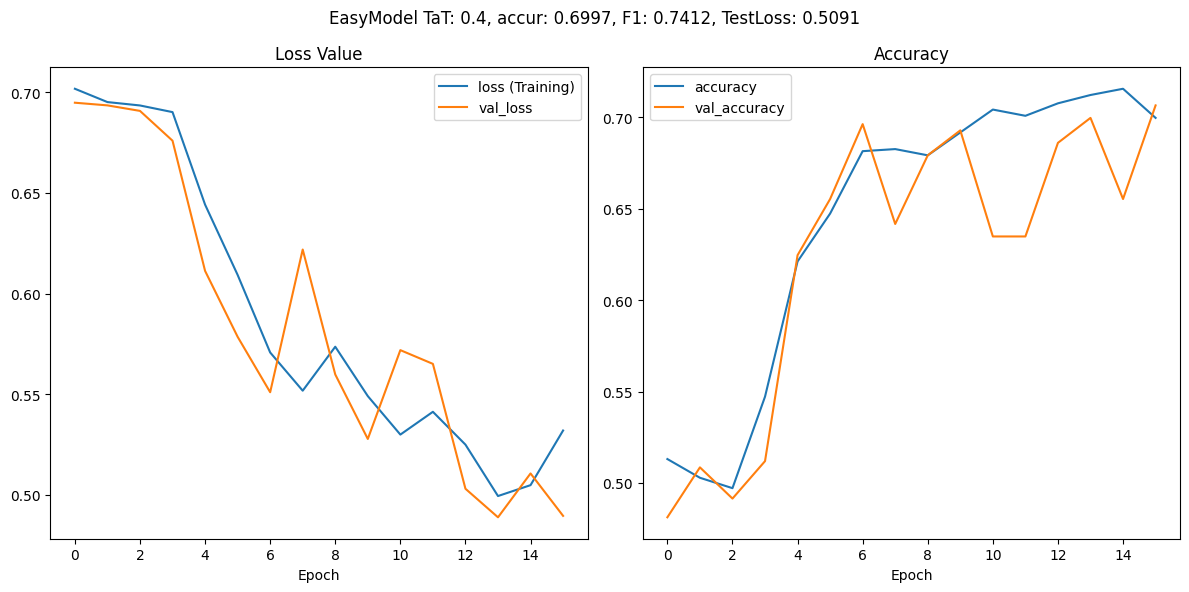

Train loss: 0.5320106744766235
Test val_loss: 0.4896377623081207
Train accuracy: 0.6996586918830872
Accuracy Score: 0.6996587030716723
F1 Score: 0.7411764705882353
Classification Report:
               precision    recall  f1-score   support

         0.0       0.73      0.57      0.64       138
         1.0       0.68      0.81      0.74       155

    accuracy                           0.70       293
   macro avg       0.71      0.69      0.69       293
weighted avg       0.70      0.70      0.69       293



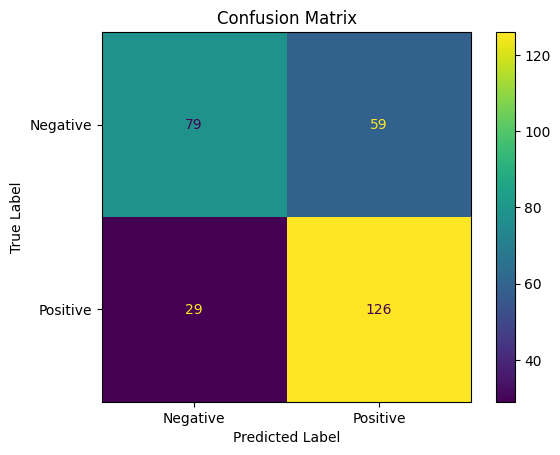

In [6]:
def build_easyModel():
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(WS_B, 1)))
    #model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=128, kernel_size=8, activation='relu')) #LeakyReLU(alpha=0.001)
    model.add(Dropout(rate=0.1))
        
    model.add(Conv1D(filters=256, kernel_size=10, activation='relu'))
    model.add(Dropout(rate=0.1))
    
    model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))

    model.add(GlobalMaxPooling1D())

    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

model = build_easyModel()
model.summary()
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=16, batch_size=32, validation_data=(X_val, y_val), verbose=1)

loss, accuracy = model.evaluate(X_test, y_test)

# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

f1 = f1_score(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))
plot_confusion_matrix(y_test, y_pred_binary)
